<a href="https://colab.research.google.com/github/steffiprog/HSE-python/blob/main/math/Untitled31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

def parse_conllu(conllu_text):
    sentences = []
    current_sent = []
    for line in conllu_text.strip().split('\n'):
        if line.startswith('#') or not line.strip():
            continue
        parts = line.split('\t')
        if len(parts) >= 10:
            token = {
                'id': int(parts[0]),
                'form': parts[1],
                'lemma': parts[2],
                'upos': parts[3],
                'xpos': parts[4],
                'feats': parts[5],
                'head': int(parts[6]),
                'deprel': parts[7],
                'deps': parts[8],
                'misc': parts[9]
            }
            current_sent.append(token)
    if current_sent:
        sentences.append(current_sent)
    return sentences

def build_dependency_tree(tokens):
    G = nx.DiGraph()

    # Добавляем все реальные узлы
    for token in tokens:
        G.add_node(token['id'], label=token['form'], upos=token['upos'])

    # Явно добавляем виртуальный корень (0), даже если его нет в данных
    if 0 not in G.nodes:
        G.add_node(0, label='ROOT', upos='ROOT')

    # Добавляем рёбра
    for token in tokens:
        head_id = token['head']
        if head_id == 0:
            G.add_edge(0, token['id'], label='root')
        else:
            G.add_edge(head_id, token['id'], label=token['deprel'])

    return G

def hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    def _hierarchy_pos(G, root, left, right, top, parent):
        pos = {root: (xcenter, top)}
        children = list(G.successors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if children:
            dx = width / len(children)
            nextx = left + dx / 2
            for child in children:
                pos.update(_hierarchy_pos(
                    G, child,
                    left=nextx - dx / 2,
                    right=nextx + dx / 2,
                    top=top - vert_gap,
                    parent=root
                ))
                nextx += dx
        return pos
    return _hierarchy_pos(G, root, 0, width, vert_loc, None)

def visualize_tree(G, tokens, figsize=(18, 12)):
    plt.figure(figsize=figsize)

    # Позиции: используем виртуальный корень 0
    pos = hierarchy_pos(G, root=0)

    # Узлы
    nx.draw_networkx_nodes(G, pos, node_size=900, node_color='lightblue', edgecolors='black')

    # Подписи узлов
    labels = {node: data['label'] for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)

    # Рёбра
    edges = G.edges()
    edge_labels = {(u, v): G[u][v]['label'] for u, v in edges}
    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9)

    plt.axis('off')
    plt.title("Синтаксическое дерево зависимостей")
    plt.tight_layout()
    plt.show()

def evaluate_complexity(G, tokens):
    # Глубина: самый длинный путь от корня (0) до листа
    try:
        # Находим все пути от 0 до листьев
        leaf_nodes = [n for n in G.nodes if G.out_degree(n) == 0 and n != 0]
        if not leaf_nodes:
            depth = 0
        else:
            paths = [nx.shortest_path(G, source=0, target=leaf) for leaf in leaf_nodes]
            depth = max(len(path) - 1 for path in paths)  # -1, т.к. считаем рёбра
    except nx.NodeNotFound:
        depth = 0

    # Максимальная ширина ветвления (макс. число исходящих рёбер у узла)
    out_degrees = [d for _, d in G.out_degree()]
    max_branching = max(out_degrees) if out_degrees else 0

    # Кросс‑зависимости: эвристика — если id ребёнка < id родителя (возможное пересечение)
    cross_deps = 0
    for u, v in G.edges():
        if u != 0 and v < u:
            cross_deps += 1

    # Плотность: рёбра / узлы
    density = G.number_of_edges() / G.number_of_nodes()

    # Частоты отношений
    deprels = [G[u][v]['label'] for u, v in G.edges()]
    rel_freq = {}
    for rel in deprels:
        rel_freq[rel] = rel_freq.get(rel, 0) + 1

    return {
        'depth': depth,
        'max_branching': max_branching,
        'cross_dependencies': cross_deps,
        'density': density,
        'relation_frequency': rel_freq
    }

In [7]:
# === ОСНОВНОЙ КОД ===
if __name__ == '__main__':
    # Ваш CONLL-U текст (можно заменить на чтение из файла)
    conllu_text = """
# newdoc
# newpar
# sent_id = 1
# text = Простое предложение — это синтаксическая единица, содержащая одну законченную мысль.
1	Простое	Простое	ADJ	JJL	Animacy=Inan|Case=Nom|Gender=Neut|Number=Sing	2	amod	_	SpacesBefore=\n
2	предложение	ПРЕДЛОЖЕНИЕ	NOUN	NN	Animacy=Inan|Case=Nom|Gender=Neut|Number=Sing	6	nsubj	_	_
3	—	—	PUNCT	,	_	2	punct	_	_
4	это	ЭТО	AUX	PRP	_	6	cop	_	_
5	синтаксическая	синтаксическая	ADJ	JJL	Animacy=Inan|Case=Nom|Gender=Fem|Number=Sing	6	amod	_	_
6	единица	ЕДИНИЦА	NOUN	NN	Animacy=Inan|Case=Nom|Gender=Fem|Number=Sing	0	root	_	SpaceAfter=No
7	,	,	PUNCT	,	_	8	punct	_	_
8	содержащая	содержащая	VERB	VBNL	Animacy=Inan|Aspect=Imp|Case=Nom|Gender=Fem|Number=Sing|Tense=Pres|VerbForm=Part|Voice=Act	6	acl	_	_
9	одну	ОДИН	NUM	CD	Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing|NumType=Card	11	nummod	_	_
10	законченную	законченную	ADJ	JJL	Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing	11	amod	_	_
11	мысль	МЫСЛЬ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing	8	obj	_	SpaceAfter=No
12	.	.	PUNCT	.	_	6	punct	_	SpacesAfter=\n
"""

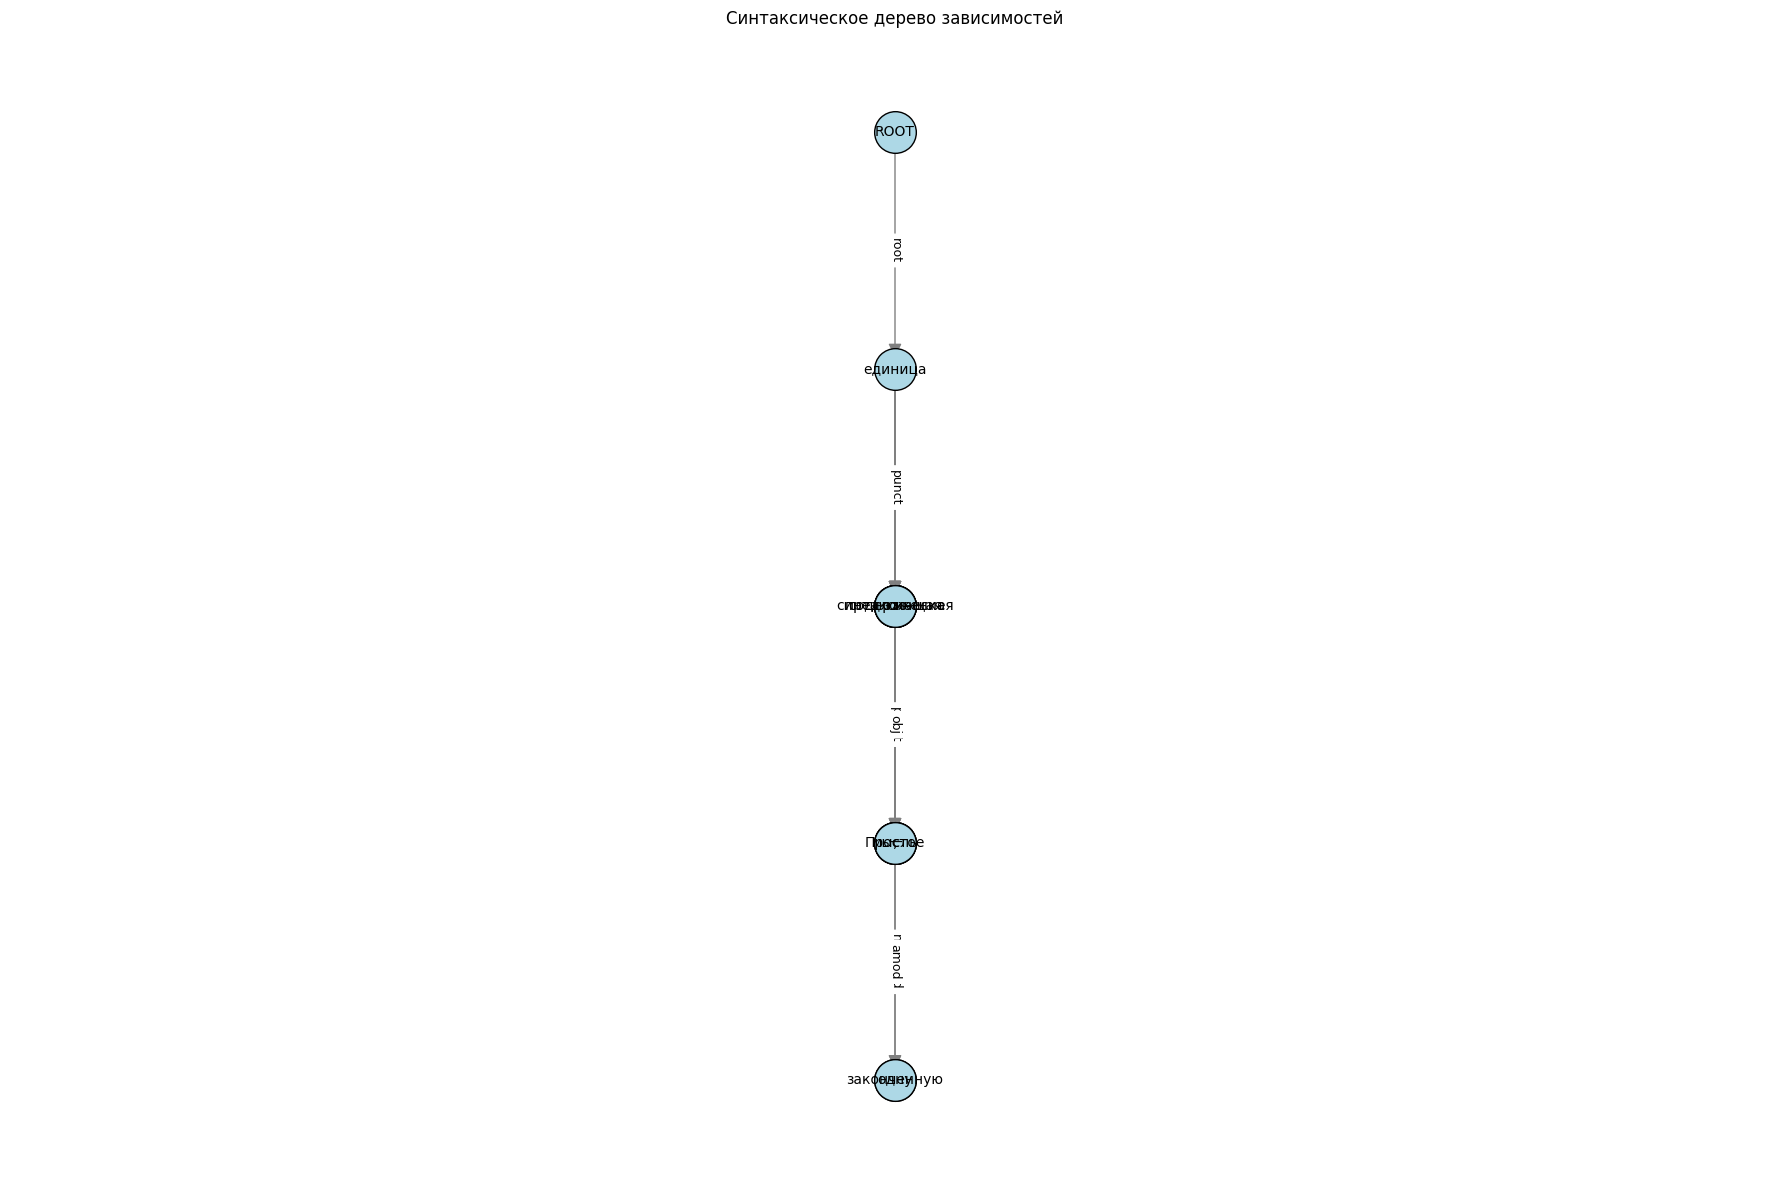

=== ОЦЕНКА СЛОЖНОСТИ СИНТАКСИЧЕСКОГО ДЕРЕВА ===
Глубина дерева: 4
Максимальная ширина ветвления: 5
Количество кросс-зависимостей: 7
Плотность зависимостей: 0.923
Частоты отношений: {'amod': 3, 'punct': 3, 'nsubj': 1, 'cop': 1, 'acl': 1, 'obj': 1, 'nummod': 1, 'root': 1}


In [8]:
    sentences = parse_conllu(conllu_text)
    tokens = sentences[0]

    G = build_dependency_tree(tokens)
    visualize_tree(G, tokens, figsize=(18, 12))

    complexity = evaluate_complexity(G, tokens)
    print("=== ОЦЕНКА СЛОЖНОСТИ СИНТАКСИЧЕСКОГО ДЕРЕВА ===")
    print(f"Глубина дерева: {complexity['depth']}")
    print(f"Максимальная ширина ветвления: {complexity['max_branching']}")
    print(f"Количество кросс-зависимостей: {complexity['cross_dependencies']}")
    print(f"Плотность зависимостей: {complexity['density']:.3f}")
    print("Частоты отношений:", complexity['relation_frequency'])